<a href="https://colab.research.google.com/github/samitha278/nanoViT/blob/main/test_vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import time
import math
import matplotlib.pyplot as plt

from dataclasses import dataclass

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## ViT Model

In [ ]:
@dataclass
class Config:
    num_classes: int = 10
    img_size: int = 28         # For MNIST
    im_channels: int = 1
    patch_size: int = 4

    n_head: int = 4
    n_layer: int = 4
    n_embd: int = 768

    dropout = 0.2

    @property
    def n_patch(self):
        return (self.img_size//self.patch_size)**2

In [2]:
class ViT(nn.Module):

    def __init__(self,config):
      super().__init__()


      self.config = config

      self.embd = PatchEmbedding(config)

      self.block = nn.ModuleList([Block(config)  for i in range(config.n_layer)])


      self.ln = nn.LayerNorm(config.n_embd)

      self.layer = nn.Linear(config.n_embd,config.num_classes)





    def forward(self,x,targets = None):

      B,C,H,W = x.shape


      #embedding
      out =  self.embd(x)

      #blocks
      for block in self.block:
        out = block(out)

      #layer norm
      out = self.ln(out)

      #linear layer
      out = self.layer(out[:,0])


      if targets is None:
        return out
      else:
        return out,F.cross_entropy(out,targets.view(-1))



#_______________________________________________________________________________


class PatchEmbedding(nn.Module):



  def __init__(self,config):
    super().__init__()

    self.config = config

    self.n_patches = config.n_patch
    self.patch_dim = config.im_channels* config.patch_size ** 2


    #patch embedding
    self.patch_embd = nn.Sequential(
        nn.LayerNorm(self.patch_dim),
        nn.Linear(self.patch_dim,config.n_embd),
        nn.LayerNorm(config.n_embd)
    )

    #cls tokens
    self.cls_token = nn.Parameter(torch.randn((config.n_embd,),device=device))

    #possitional embedding
    self.pos_embd = nn.Embedding(self.n_patches+1,config.n_embd)    # +1 for cls token





  def forward(self,x):

    B,C,H,W = x.shape

    # B,C,H,W -> B, n_patches , patch_dim    # patch_dim = C* patch_size*patch_size

    patch_size = self.config.patch_size

    patches = F.unfold(x, patch_size, stride = patch_size).transpose(-1,-2)

    #patch embedding
    patch_embd = self.patch_embd(patches)        # B, n_patches , n_embd

    #class token
    class_tok = self.cls_token.expand(B,1,-1)     # B , 1 , n_embd


    patch_embd = torch.cat((class_tok,patch_embd),dim =1 )    # B, n_patches +1  , n_embd

    #positional embedding
    pos_embd = self.pos_embd(torch.arange(0,self.n_patches+1,device=device))     # B, n_patches +1  , n_embd

    out = patch_embd + pos_embd

    return out





#_______________________________________________________________________________



class Block(nn.Module):


  def __init__(self,config):
    super().__init__()



    self.ln_1 = nn.LayerNorm(config.n_embd)
    self.attn = Attention(config.n_embd,config.n_head)
    self.ln_2 = nn.LayerNorm(config.n_embd)
    self.mlp = MLP(config.n_embd)


  def forward(self,x):

    x = x + self.attn(self.ln_1(x))
    x = x + self.mlp(self.ln_2(x))

    return x


#_______________________________________________________________________________


class MLP(nn.Module):


  def __init__(self,n_embd):
    super().__init__()


    self.layer = nn.Linear(n_embd,4*n_embd)
    self.gelu = nn.GELU()
    self.proj = nn.Linear(4*n_embd,n_embd)
    self.dropout = nn.Dropout(0.2)


  def forward(self,x):


    x = self.gelu(self.layer(x))
    x = self.proj(x)
    x = self.dropout(x)

    return x


#_______________________________________________________________________________


class Attention(nn.Module):


  def __init__(self,n_embd,n_head) :
    super().__init__()

    self.nh = n_head

    self.w = nn.Linear(n_embd,3*n_embd)    # 3 * n_head * head_size
    self.proj = nn.Linear(n_embd,n_embd)


  def forward(self,x):

    B,T,C = x.shape

    wei = self.w(x)        # B,T, 3* C

    k,q,v = torch.chunk(wei,3, dim = -1)      # each B,T,C

    head_size = C//self.nh

    key   = k.view(B, T, self.nh, head_size).transpose(1, 2)    # B, n_head, T, head_size
    query = q.view(B, T, self.nh, head_size).transpose(1, 2)    # ""
    value = v.view(B, T, self.nh, head_size).transpose(1, 2)


    # weight = ( query @ key.transpose(-1,-2) )  * (head_size ** -0.5)    #B,nh,T,T
    # weight = F.softmax(weight,dim = -1)

    # out = weight @ value      #B,nh,T,n_head


    #Flash Attention
    out = F.scaled_dot_product_attention(query,key,value)



    out = out.transpose(1,2).view(B,T,C)    #B,T,nh,n_head

    out = self.proj(out)

    return out



# MNIST

In [ ]:
transform_train = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform_train)
val_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform_train)


# Train

In [ ]:
torch.manual_seed(278)
if torch.cuda.is_available():
    torch.cuda.manual_seed(278)

batch_size = 32


train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
torch.manual_seed(278)
if torch.cuda.is_available():
    torch.cuda.manual_seed(278)

max_iter = 1000
lr = 6e-4


vit = ViT(Config())
vit = vit.to(device)
vit = torch.compile(vit)


use_fused = True if torch.cuda.is_available() else False
optimizer = torch.optim.AdamW(vit.parameters(),lr = lr,fused = use_fused)

losses = torch.zeros((max_iter,))

train_data_iter = iter(train_data)

for i in range(max_iter):


    t0 = time.time()

    try:
        xb,yb = next(train_data_iter)
    except StopIteration:
         train_data_iter = iter(train_data)   # reset
         xb,yb = next(train_data_iter)

    xb,yb = xb.to(device),yb.to(device)


    logits , loss = vit(xb,yb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    torch.cuda.synchronize() if torch.cuda.is_available() else None

    t1 = time.time()
    dt = (t1-t0) * 1000 # ms

    losses[i] = loss.item()

    if i%100 ==0 : print(f'{i}/{max_iter}  {loss.item():.4f}  {dt:.4f} ms')






0/1000  2.2685  131.6884 ms
100/1000  0.8162  88.0437 ms
200/1000  0.9531  85.7632 ms
300/1000  2.0218  89.4675 ms
400/1000  0.7352  87.0714 ms
500/1000  0.4921  83.8625 ms
600/1000  0.7189  87.1720 ms
700/1000  0.7873  88.3372 ms
800/1000  0.9585  88.5544 ms
900/1000  0.7969  86.7596 ms


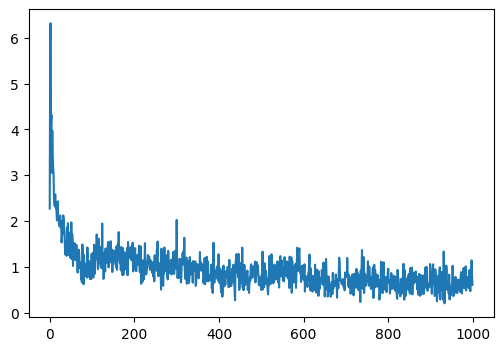

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.show()

## Accuracy for full val_data

In [ ]:
torch.manual_seed(278)
if torch.cuda.is_available():
    torch.cuda.manual_seed(278)

correct, total = 0, 0
for xb, yb in val_data:
    xb,yb = xb.to(device),yb.to(device)
    logits = vit(xb)
    preds = torch.argmax(logits, dim=-1)
    correct += (preds == yb).sum().item()
    total += yb.size(0)

val_acc = correct / total
print(f"Validation accuracy: {val_acc:.4f}")

Validation accuracy: 0.8095


# CIFAR 10

In [3]:
transform_train = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=transform_train)
val_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=transform_train)

100%|██████████| 170M/170M [00:04<00:00, 35.2MB/s]


In [ ]:
torch.manual_seed(278)
if torch.cuda.is_available():
    torch.cuda.manual_seed(278)

batch_size = 32


train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
x,y = next(iter(train_data))

x.shape,max(y)

(torch.Size([32, 3, 32, 32]), tensor(9))

In [ ]:
@dataclass
class Config:
    num_classes: int = 10
    img_size: int = 32         # For CIFAR
    im_channels: int = 3
    patch_size: int = 8

    n_head: int = 4
    n_layer: int = 4
    n_embd: int = 768

    dropout = 0.2

    @property
    def n_patch(self):
        return (self.img_size//self.patch_size)**2

In [ ]:
torch.manual_seed(278)
if torch.cuda.is_available():
    torch.cuda.manual_seed(278)

max_iter = 1000
lr = 6e-4


vit = ViT(Config())
vit = vit.to(device)
vit = torch.compile(vit)


use_fused = True if torch.cuda.is_available() else False
optimizer = torch.optim.AdamW(vit.parameters(),lr = lr,fused = use_fused)

losses = torch.zeros((max_iter,))

train_data_iter = iter(train_data)

for i in range(max_iter):


    t0 = time.time()

    try:
        xb,yb = next(train_data_iter)
    except StopIteration:
         train_data_iter = iter(train_data)   # reset
         xb,yb = next(train_data_iter)

    xb,yb = xb.to(device),yb.to(device)


    logits , loss = vit(xb,yb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    torch.cuda.synchronize() if torch.cuda.is_available() else None

    t1 = time.time()
    dt = (t1-t0) * 1000 # ms

    losses[i] = loss.item()

    if i%100 ==0 : print(f'{i}/{max_iter}  {loss.item():.4f}  {dt:.4f} ms')

W0928 15:31:09.810000 174 torch/_inductor/utils.py:1436] [0/1] Not enough SMs to use max_autotune_gemm mode


0/1000  2.3342  51567.6496 ms
100/1000  2.3094  40.5657 ms
200/1000  2.1336  37.4801 ms
300/1000  2.3655  38.1184 ms
400/1000  1.8908  39.4473 ms
500/1000  1.8144  38.4216 ms
600/1000  1.7888  39.7465 ms
700/1000  2.0120  39.7189 ms
800/1000  1.7470  40.0531 ms
900/1000  1.9166  40.8957 ms


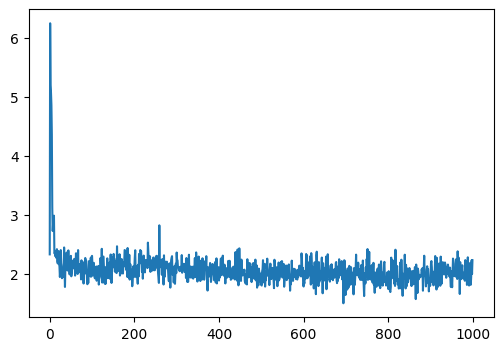

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.show()

## Accuracy for full val_data

In [ ]:
torch.manual_seed(278)
if torch.cuda.is_available():
    torch.cuda.manual_seed(278)

correct, total = 0, 0
for xb, yb in val_data:
    xb,yb = xb.to(device),yb.to(device)
    logits = vit(xb)
    preds = torch.argmax(logits, dim=-1)
    correct += (preds == yb).sum().item()
    total += yb.size(0)

val_acc = correct / total
print(f"Validation accuracy: {val_acc:.4f}")

Validation accuracy: 0.2684


## Improving : LR Schedule , Weight Decay , Gradient Clipping

In [4]:
@dataclass
class Config:
    num_classes: int = 10
    img_size: int = 32         # For CIFAR
    im_channels: int = 3
    patch_size: int = 8        # try chaniging

    n_head: int = 4
    n_layer: int = 4
    n_embd: int = 768

    dropout = 0.2

    @property
    def n_patch(self):
        return (self.img_size//self.patch_size)**2

In [5]:
torch.manual_seed(278)
if torch.cuda.is_available():
    torch.cuda.manual_seed(278)

batch_size = 32


train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [7]:
torch.manual_seed(278)
if torch.cuda.is_available():
    torch.cuda.manual_seed(278)




vit = ViT(Config())
vit = vit.to(device)
vit = torch.compile(vit)


#------------------------------------------------------------------------------4

max_iter = 1000
warm_up = max_iter *0.05
max_lr = 6e-4
min_lr = max_lr * 0.1



def get_lr(i):

    if i < warm_up:
        return (max_lr/warm_up) * (i+1)

    if i>max_iter :
        return min_lr

    # cosine decay
    diff = max_lr - min_lr
    steps = max_iter - warm_up
    lr = (diff/2) * math.cos(i * (math.pi / steps)) + diff
    return lr


#------------------------------------------------------------------------------


losses = torch.zeros((max_iter,))
lrs = torch.zeros((max_iter,))
norms = torch.zeros((max_iter,))



# Optimizer
use_fused = True if torch.cuda.is_available() else False
optimizer = torch.optim.AdamW(vit.parameters(),lr = max_lr,weight_decay = 0.1,fused = use_fused)


train_data_iter = iter(train_data)

for i in range(max_iter):


    t0 = time.time()

    try:
        xb,yb = next(train_data_iter)
    except StopIteration:
         train_data_iter = iter(train_data)   # reset
         xb,yb = next(train_data_iter)

    xb,yb = xb.to(device),yb.to(device)


    logits , loss = vit(xb,yb)

    optimizer.zero_grad()
    loss.backward()


    # LR Schedule
    lr = get_lr(i)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Gradient Clipping
    norm = torch.nn.utils.clip_grad_norm_(vit.parameters(),1.0)

    optimizer.step()

    torch.cuda.synchronize() if torch.cuda.is_available() else None

    t1 = time.time()
    dt = (t1-t0) * 1000 # ms

    losses[i] = loss.item()
    lrs[i] = lr
    norms[i] = norm

    if i%100 ==0 : print(f'{i}/{max_iter}  {loss.item():.4f}  {dt:.4f} ms   norm:{norm.item():.4f}   lr:{lr:.4e}')

W0929 17:23:38.043000 686 torch/_inductor/utils.py:1436] [0/0] Not enough SMs to use max_autotune_gemm mode


0/1000  2.3342  23087.0581 ms   norm:7.0133   lr:1.2000e-05
100/1000  2.4822  37.9224 ms   norm:7.2206   lr:7.9537e-04
200/1000  2.5106  40.9629 ms   norm:6.9095   lr:7.5307e-04
300/1000  2.3512  37.1890 ms   norm:7.1988   lr:6.8768e-04
400/1000  1.9129  38.3921 ms   norm:5.2334   lr:6.0628e-04
500/1000  1.8971  36.9473 ms   norm:5.1916   lr:5.1770e-04
600/1000  1.8100  37.8897 ms   norm:3.7129   lr:4.3154e-04
700/1000  1.9884  37.7500 ms   norm:3.8145   lr:3.5713e-04
800/1000  1.8460  40.1011 ms   norm:3.9867   lr:3.0254e-04
900/1000  1.8357  37.7097 ms   norm:3.8326   lr:2.7368e-04


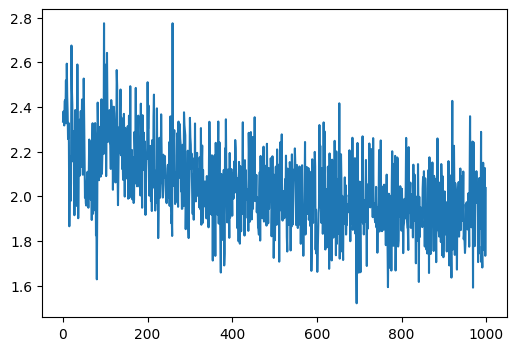

In [8]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.show()

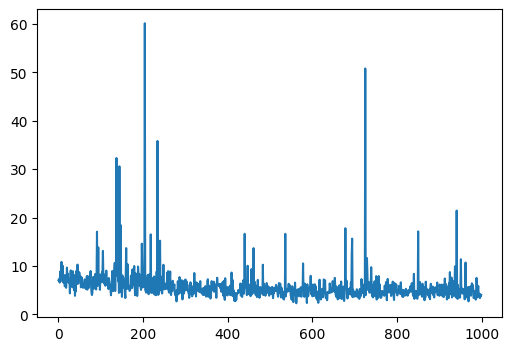

In [9]:
plt.figure(figsize=(6,4))
plt.plot(norms)
plt.show()

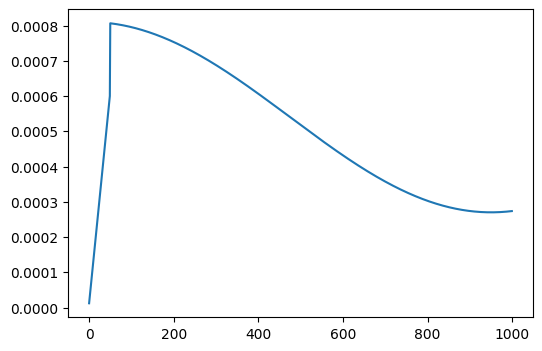

In [10]:
plt.figure(figsize=(6,4))
plt.plot(lrs)
plt.show()

## Accuracy for full val_data

In [11]:
torch.manual_seed(278)
if torch.cuda.is_available():
    torch.cuda.manual_seed(278)

correct, total = 0, 0
for xb, yb in val_data:
    xb,yb = xb.to(device),yb.to(device)
    logits = vit(xb)
    preds = torch.argmax(logits, dim=-1)
    correct += (preds == yb).sum().item()
    total += yb.size(0)

val_acc = correct / total
print(f"Validation accuracy: {val_acc:.4f}")

Validation accuracy: 0.2956
